In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import torch
import torch.nn as nn
from torch.optim import RMSprop

from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = pd.read_csv('../data/jhu-covid-cases.csv')
data = data[data.Province_State == 'West Virginia']
data = data[data.columns[11:]]
print(data.columns[:5])

death = pd.read_csv('../data/jhu-covid-deaths.csv')
death = death[death.Province_State == 'West Virginia']
death = death[death.columns[12:]]
print(death.columns[:5]) # make sure the dates match

data = np.array(data.sum(axis = 0)) #.reshape(-1, 1)
data = np.convolve(data, np.ones(7) / 7, 'valid')
data = torch.tensor(data)
Itilde = torch.log(1 + data[20:] - data[:-20]).reshape(1, -1)

death = torch.tensor(death.sum(axis = 0))
Dt = torch.tensor(np.convolve(death, np.ones(7) / 7, 'valid'))
Dtilde = torch.log(1 + Dt[:-20]).reshape(1, -1)

N = 1_775_000 
Ntilde = math.log(N)

Stilde = torch.log(N - torch.exp(Itilde) - torch.exp(Dtilde))

first_index = torch.arange(1117)[Itilde[0,:] > 4.6][0].item() # first index above 100 cases 

Stilde = Stilde[:,first_index:].T
Itilde = Itilde[:,first_index:].T
Dtilde = Dtilde[:,first_index:].T

Y = torch.hstack((Stilde, Itilde, Dtilde))
T = torch.arange(1073).reshape(-1, 1) * 1.

print(T.shape, Y.shape) # make sure shapes match 

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
torch.Size([1073, 1]) torch.Size([1073, 3])


In [107]:
class Greek(nn.Module): # 1 to 1 (time to positive value)
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 32)
        self.lin2 = nn.Linear(32, 32)
        self.lin3 = nn.Linear(32, 32)
        self.lin4 = nn.Linear(32, 1)

        self.act = nn.GELU()

        #self.param = nn.Parameter(torch.randn(1078, 1))

    #"""
    def forward(self, x):
        x = x / 1000 # ich hab kein lust das zu preprocessieren :P
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)
        x = self.act(x)
        x = self.lin3(x)
        x = self.act(x)
        x = self.lin4(x)
        return 1 + torch.sin(x)

    #"""
    #def forward(self, t):
    #    print(t)
    #    return torch.exp(self.param[t])

class Curves(nn.Module): # put all 3 in 1
    def __init__(self, T = 1078):
        super().__init__()
        self.lin1 = nn.Linear(1, 48)
        self.lin2 = nn.Linear(48, 48)
        self.lin3 = nn.Linear(48, 48)
        self.lin4 = nn.Linear(48, 48)
        self.lin5 = nn.Linear(48, 3)

        self.act = nn.GELU()

        self.gamma = Greek()
        self.beta = Greek()
        self.mu = Greek()

    def forward(self, x): # takes time and produces S, I, T estimates
        x = x / 1000 # again to avoid preprocessing
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)
        x = self.act(x)
        x = self.lin3(x)
        x = self.act(x)
        x = self.lin4(x)
        x = self.act(x)
        x = self.lin5(x)

        return Ntilde * x # so the model only has to predict something smaller

    def get_derivative(self, t):
        t.requires_grad = True
        
        x = self.forward(t)

        grad_s = torch.autograd.grad(x[:,0].sum(), t, create_graph=True)[0]
        grad_i = torch.autograd.grad(x[:,1].sum(), t, create_graph=True)[0]
        grad_d = torch.autograd.grad(x[:,2].sum(), t, create_graph=True)[0]
        
        return grad_s, grad_i, grad_d


=== Epoch 0 | PDE: 24.1449 | Curve: 78.2173 | Boundary: 144931024.0 ===


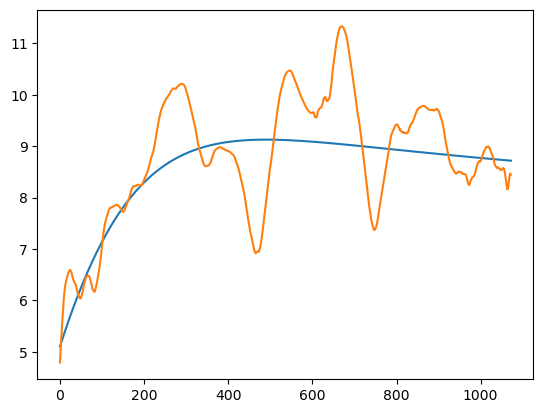

=== Epoch 20 | PDE: 0.0188 | Curve: 30.6572 | Boundary: 9461398.0 ===
=== Epoch 40 | PDE: 0.0008 | Curve: 21.9399 | Boundary: 9490839.0 ===
=== Epoch 60 | PDE: 0.0053 | Curve: 35.8632 | Boundary: 34909220.0 ===
=== Epoch 80 | PDE: 0.0049 | Curve: 19.2021 | Boundary: 68496240.0 ===
=== Epoch 100 | PDE: 0.0083 | Curve: 14.1934 | Boundary: 230890960.0 ===


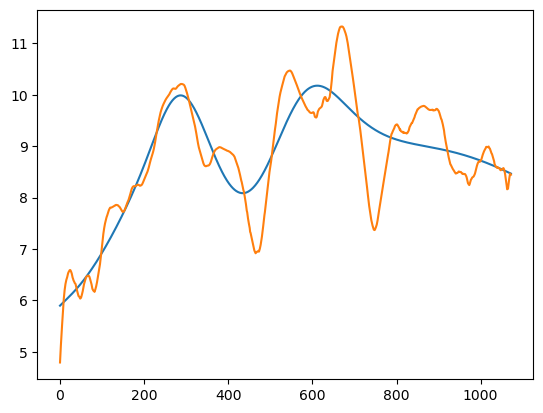

=== Epoch 120 | PDE: 0.0087 | Curve: 13.4855 | Boundary: 229976928.0 ===
=== Epoch 140 | PDE: 0.007 | Curve: 8.7517 | Boundary: 24801390.0 ===
=== Epoch 160 | PDE: 0.0122 | Curve: 7.7372 | Boundary: 17646554.0 ===
=== Epoch 180 | PDE: 0.0131 | Curve: 13.0683 | Boundary: 55627452.0 ===
=== Epoch 200 | PDE: 0.0035 | Curve: 7.4537 | Boundary: 238914320.0 ===


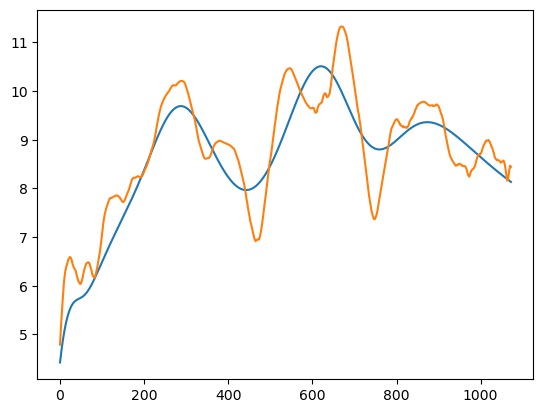

=== Epoch 220 | PDE: 0.0045 | Curve: 4.5345 | Boundary: 34739012.0 ===
=== Epoch 240 | PDE: 0.026 | Curve: 3.6593 | Boundary: 86588400.0 ===
=== Epoch 260 | PDE: 0.0185 | Curve: 6.2554 | Boundary: 44326184.0 ===
=== Epoch 280 | PDE: 0.0196 | Curve: 7.3792 | Boundary: 47796284.0 ===
=== Epoch 300 | PDE: 0.0146 | Curve: 6.8363 | Boundary: 49888520.0 ===


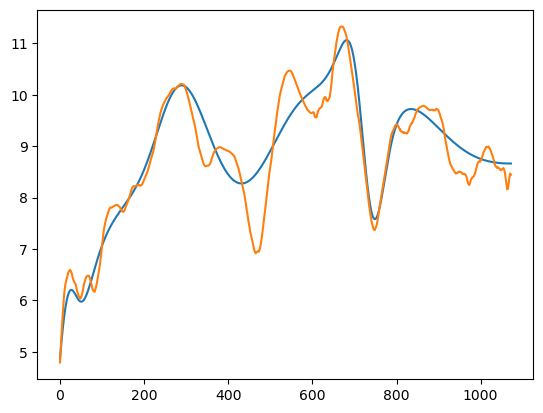

=== Epoch 320 | PDE: 0.0085 | Curve: 2.6867 | Boundary: 31190186.0 ===
=== Epoch 340 | PDE: 0.0133 | Curve: 6.7525 | Boundary: 68521272.0 ===
=== Epoch 360 | PDE: 0.0177 | Curve: 4.6028 | Boundary: 1285851520.0 ===
=== Epoch 380 | PDE: 0.0236 | Curve: 3.7725 | Boundary: 90553096.0 ===
=== Epoch 400 | PDE: 0.0278 | Curve: 4.5696 | Boundary: 70489096.0 ===


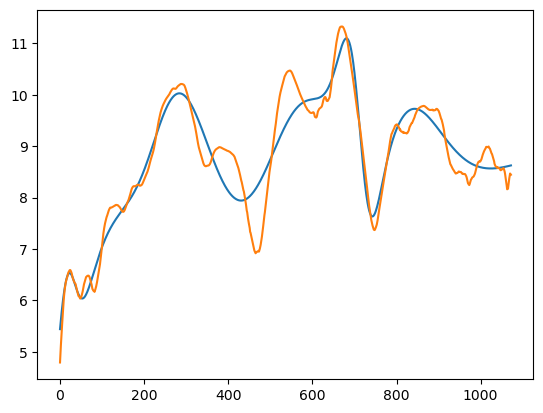

=== Epoch 420 | PDE: 0.0475 | Curve: 4.776 | Boundary: 204462160.0 ===
=== Epoch 440 | PDE: 0.0235 | Curve: 2.7093 | Boundary: 68538352.0 ===
=== Epoch 460 | PDE: 0.5341 | Curve: 3.9691 | Boundary: 59241248.0 ===
=== Epoch 480 | PDE: 0.036 | Curve: 3.9094 | Boundary: 82248552.0 ===


In [ ]:
NN = Curves()
optimizer = RMSprop(NN.parameters(), lr = 1e-3)

EPOCHS = 2020

T_pde = 1073 * torch.rand(1073).reshape(-1, 1) # points to bee used for the self normalizing pde loss
dataset = DataLoader(TensorDataset(T, Y, T_pde), batch_size = 35, shuffle = True)
losses = []

for i in range(EPOCHS):

    total_loss = 0.

    for t, y, t_pde in dataset:
        optimizer.zero_grad()
        
        y_hat = NN(t)

        ## assemble losses
        ### distance from the model output to the actual curves
        curve_loss = torch.sum((y - y_hat)**2)
        
        ### pde losses
        if i >= 1000:
            with torch.no_grad():
                dsdt, didt, dddt = NN.get_derivative(t_pde)
                y_hat_pde = NN(t_pde)
        else:
            dsdt, didt, dddt = NN.get_derivative(t_pde)
            y_hat_pde = NN(t_pde)

        mu_t = NN.mu(t_pde)
        beta_t = NN.beta(t_pde)
        gamma_t = NN.gamma(t_pde)

        dsdt_hat = gamma_t * torch.exp(y_hat_pde[:,1] - y_hat_pde[:,0]).reshape(-1, 1) - beta_t * torch.exp(y_hat_pde[:,1] - Ntilde).reshape(-1, 1) # ok
        didt_hat = beta_t * torch.exp(y_hat_pde[:,0] - Ntilde).reshape(-1, 1) - gamma_t - mu_t # ok
        dddt_hat = mu_t * torch.exp(y_hat_pde[:,1] - y_hat_pde[:,2]).reshape(-1, 1) # ok

        # print(dsdt_hat.shape, didt_hat.shape, dddt_hat.shape)

        dsdt_loss = torch.sum((dsdt - dsdt_hat)**2)
        dddt_loss = torch.sum((dddt - dddt_hat)**2)
        didt_loss = torch.sum((didt - didt_hat)**2)

        pde_loss = dddt_loss + dsdt_loss + didt_loss

        ### boundary loss
        pde_bound = torch.sum(((torch.exp(y_hat_pde[:,0]).reshape(-1, 1) * dsdt) + \
                               (torch.exp(y_hat_pde[:,1]).reshape(-1, 1) * didt) + \
                               (torch.exp(y_hat_pde[:,2]).reshape(-1, 1) * dddt))**2)
        curve_bound = torch.sum((Ntilde - torch.log(torch.exp(y_hat_pde).sum(axis = 1)))**2)

        boundary_loss = pde_bound + curve_bound
        
        ### total loss assemble
        if i < 1000:
            l = torch.log(curve_loss + 0.01 * pde_loss) # + 1e-6 * boundary_loss) 
        else:
            l = torch.log(curve_loss + 1000 * pde_loss) # + 0.001 * boundary_loss) 
        
        l.backward()
        optimizer.step()

        total_loss += l.item() #.detach()

    losses.append(total_loss)

    if i % 100 == 10:
        with torch.no_grad():
            plt.plot(NN(T)[:,1])
            plt.plot(Itilde)
            plt.show()
        
    if i % 20 == 0:
        print('=== Epoch', i, '| PDE:', round(pde_loss.item(), 4), '| Curve:', round(curve_loss.item(), 4), '| Boundary:', round(boundary_loss.item(), 4),  '===')


In [ ]:
plt.plot(losses[20:])

In [ ]:
with torch.no_grad():
    plt.plot(NN(T)[:,2])
    plt.plot(Dtilde)

In [ ]:
with torch.no_grad():
    plt.plot(NN(T)[:,1])
    plt.plot(Itilde)

In [ ]:
with torch.no_grad():
    plt.plot(NN.beta(T)[:,0])

In [ ]:
with torch.no_grad():
    plt.plot(NN.gamma(T)[:,0])

In [ ]:
with torch.no_grad():
    plt.plot(NN.mu(T)[:,0])

## plug this into a pde solver to make sure the curve works

In [101]:
S0 = Stilde[0,0].item()
I0 = Itilde[0,0].item()
D0 = Dtilde[0,0].item()

S0, I0, D0

(14.389242648577175, 4.789869865187013, 0.0)

In [102]:
St = [S0]
It = [I0]
Dt = [D0]

dt = 0.1 

for i in range(500 * 10): # simulate the first 500 days

    i_tensor = torch.tensor([[i * dt]])

    with torch.no_grad():
        beta = NN.beta(i_tensor).item()
        gamma = NN.gamma(i_tensor).item()
        mu = NN.mu(i_tensor).item()

    dS = gamma * math.exp(It[-1] - St[-1]) - beta * math.exp(It[-1] - Ntilde)
    dI = beta * math.exp(St[-1] - Ntilde) - mu - gamma
    dD = mu * math.exp(It[-1] - Dt[-1])

    S = St[-1] + (dt * dS)
    I = It[-1] + (dt * dI)
    D = Dt[-1] + (dt * dD)

    St.append(S)
    It.append(I)
    Dt.append(D)


St = torch.tensor(St)
It = torch.tensor(It)
Dt = torch.tensor(Dt)

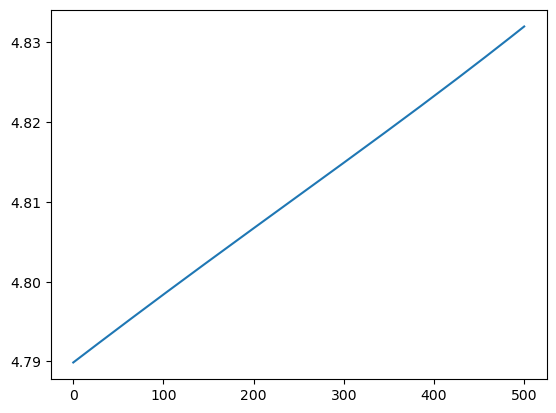

In [105]:
plt.plot(It[::10])
#plt.plot(Itilde[:500])

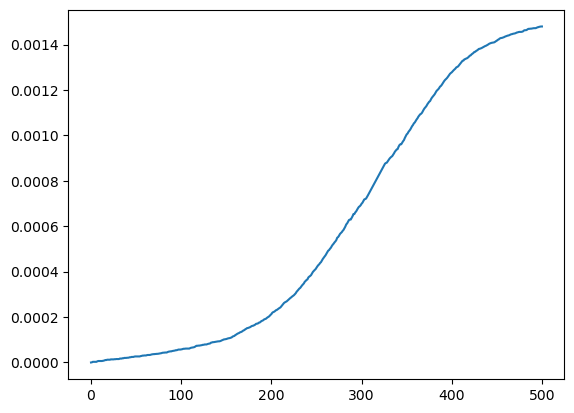

In [106]:
plt.plot(Dt[::10])
#plt.plot(Dtilde[:500])